In [1]:
import sys
sys.path.insert(0, '..') 
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import math
relu = torch.nn.ReLU()

from src.vanilla_rnn import VanillaRNN

/Users/alexnegron/miniconda3/envs/torch/lib/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448801785/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


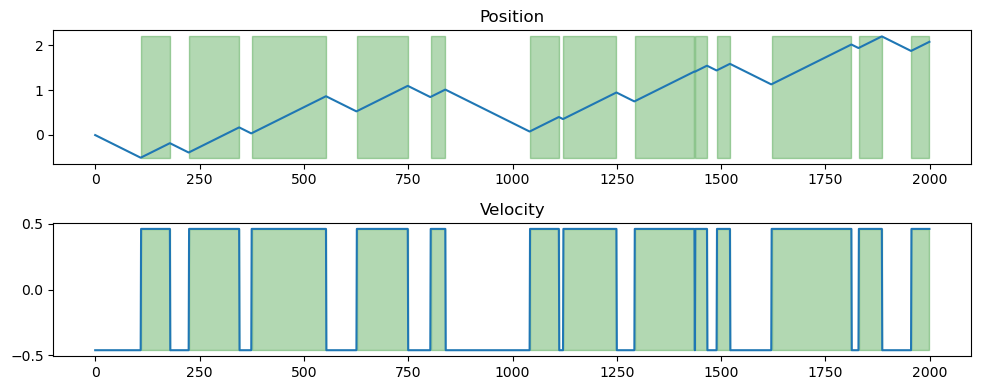

In [3]:
# training data generation
from tasks.independent_integration_task import generate_dataset

num_samples = 1
num_trajectories = 3
num_timesteps = 2000
flip_rate = 1e-2
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   flip_rate=flip_rate,
                                   omega_value=omega_value,
                                   gain=True
                                   )

# Plot the dataset
traj_idx = 0
for i in range(num_samples)[::]:
    fig, axs = plt.subplots(2, 1, figsize=(10, 4))

    # Compute the angle from the target positions
    angle = np.arctan2(targets[i, :, 2*traj_idx+1], targets[i, :, 2*traj_idx])

    # Plot corresponding position from targets
    axs[0].plot(angle)
    axs[0].set_title('Position')

    # Shade regions where position is increasing
    axs[0].fill_between(range(len(angle)), angle.min(), angle.max(), where=np.diff(angle, prepend=0) > 0, color='green', alpha=0.3)

    # Plot omega trajectory
    velocity = inputs[i, :, traj_idx]
    axs[1].plot(velocity)
    axs[1].set_title('Velocity')

    # Shade regions where velocity is positive
    axs[1].fill_between(range(len(velocity)), velocity.min(), velocity.max(), where=velocity > 0, color='green', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [10]:
# initialize the network 
torch.set_default_tensor_type(torch.DoubleTensor)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.set_default_tensor_type(torch.FloatTensor)
# device = 'mps' if torch.backends.mps.is_built() else 'cpu'
print(f'device = {device}')

num_samples = 1
num_trajectories = 10
num_timesteps = 2000
flip_rate = 1e-2
# omega_process = 'constant'
omega_process = 'binary'
omega_value = 0.5
dt = .01

# Generate the dataset
inputs, targets = generate_dataset(num_samples,
                                   num_timesteps,
                                   num_trajectories,
                                   trajectory_type=omega_process,
                                   dt=dt,
                                   flip_rate=flip_rate,
                                   omega_value=omega_value,
                                   gain=True
                                   )

input_size = inputs.shape[2]
output_size = targets.shape[2]
nNeurons = 200 * num_trajectories


net = VanillaRNN(input_size,
             output_size,
             device=device,
             nNeurons=nNeurons,
             dt=.5,
             tau=10.0,
            )

criterion = torch.nn.MSELoss()
learning_rate = 5e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
num_epochs = 200
clip_value = 2 # Define the gradient clip value

losses = []
perfs = []
hidden_activity = torch.zeros((num_epochs, num_samples, num_timesteps, nNeurons)) # store hidden activity

for epoch in range(num_epochs):
    running_loss = 0.0
    indices = torch.randperm(num_samples)

    for i in range(num_samples):

        idx = indices[i]
        x = torch.Tensor(inputs[idx]).unsqueeze(1).to(device)
        y = torch.Tensor(targets[idx]).unsqueeze(1).to(device)

        outputs, activity = net(x)
        hidden_activity[epoch, i, :] = activity.squeeze(1).detach().cpu()[:, :]
        
        # outputs = torch.Tensor(outputs).unsqueeze(1)
        outputs = torch.Tensor(outputs)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping step after backpropagation and before optimization step
        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / num_samples
    losses.append(avg_loss)
    percent_complete = ((epoch+1) / num_epochs) * 100
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Average train loss: {avg_loss:.20f}')

    if running_loss/num_samples < 0.001:
        print(f'Training stopped early at epoch {epoch+1} because the average loss fell below 0.05')
        break

device = cpu


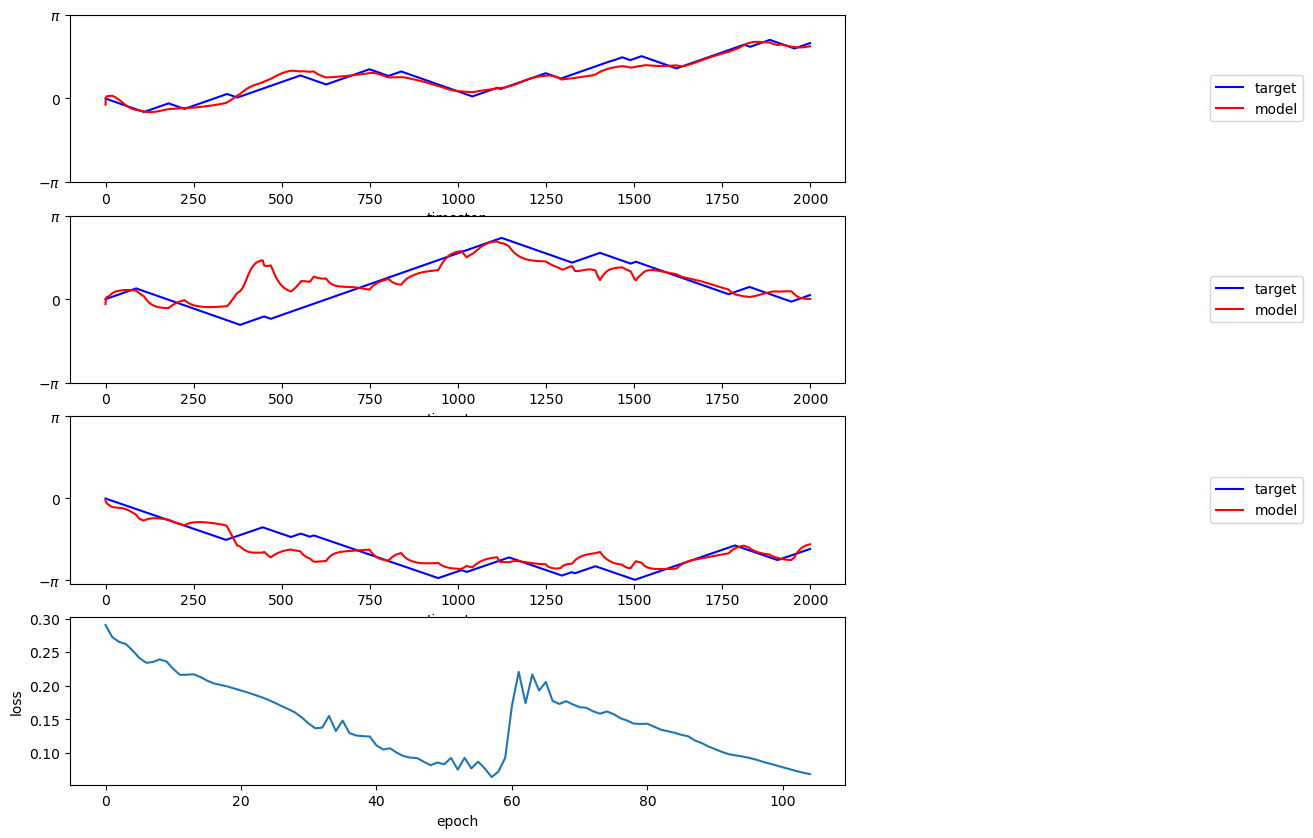

In [8]:
fig, ax = plt.subplots(1 + num_trajectories, 1, figsize=(10,10))
sample_idx = 0
targets_to_plot = targets[sample_idx, :, :]
x = torch.Tensor(inputs[sample_idx, :, :]).unsqueeze(1)

# forward pass
outputs, _ = net(x)
output_arr = outputs.detach().cpu().numpy()

ax[-1].plot(losses[10:])  
ax[-1].set_xlabel('epoch')
ax[-1].set_ylabel('loss') # set y label


for i in range(0, num_trajectories):
    ax[i].plot(range(targets.shape[1]), np.arctan2(targets[sample_idx, :, 2*i+1], targets[sample_idx, :, 2*i]), label='target', color='blue')
    ax[i].plot(range(targets.shape[1]), np.arctan2(output_arr.squeeze(1)[:, 2*i+1], output_arr.squeeze(1)[:, 2*i]), label='model', color='red')
    ax[i].set_xlabel('timestep') # set x label
    ax[i].set_yticks(np.linspace(-np.pi, np.pi, 3), [r'$-\pi$', r'$0$', r'$\pi$'])
    ax[i].legend(loc='center right', bbox_to_anchor=(1.6, 0.5))

plt.show()